In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte

# Don't forget to make F_L, F_R lists
# Make everything work with eps list
# Comment and delete old methods
# Make sure all imports are relevant


In [2]:
def main():
    # Initialize the simulation parameters
    N = 1
    gamma_L= 3
    gamma_R = 0.5
    eps = 1
    mu_L= 2
    mu_R= 1
    T_L = 1
    T_R= 1
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 0

    eps_list = []

    for i in range(N):
        eps_list.append(1)

  
    time = 3.0
    dt = 0.1
    nt = int(time/dt)

    

 

    exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

    print("Exact Ham", exact_diag_ham)

   #printexact_diag_hamiltonian)
    ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R,J)
    print("Ham real", ham_real)
    print("Ham imag", ham_imag)



    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
    print("Exact Initial State", exact_diag_init_state)
    print("VQTE initial State", vqte_init_state)

    exact_diag_results = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)
    print(exact_diag_results)
 
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    
    # # Output results
    output_results(vqte_results, exact_diag_results, time, nt)

Exact Ham [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Ham real SparsePauliOp(['ZI', 'IZ', 'XY', 'YX', 'YX', 'XY'],
              coeffs=[ 0.5       +0.j, -0.5       +0.j,  0.34658787+0.j,  0.34658787+0.j,
 -0.        +0.j, -0.        +0.j])
Ham imag SparsePauliOp(['XX', 'YY', 'II', 'ZI', 'IZ', 'XX', 'YY', 'II', 'ZI', 'IZ'],
              coeffs=[-0.75      +0.j,  0.75      +0.j,  1.5       +0.j,  0.34658787+0.j,
  0.34658787+0.j, -0.125     +0.j,  0.125     +0.j,  0.25      +0.j,
 -0.        +0.j, -0.        +0.j])
Exact Initial State [[ 1.0000000e+00+7.34788079e-16j -3.6739404e-16-8.99855870e-32j]
 [-2.4492936e-16-2.99951957e-32j -1.2246468e-16-5.47382213e-48j]]
VQTE initial State Statevector([ 1.0000000e+00+7.34788079e-16j,
             -2.4492936e-16-2.99951957e-32j,
             -3.6739404e-16-8.99855870e-32j,
             -1.2246468e-16-5.47382213e-48j],
            dims=(2, 2))
Exact diag initial: -1.2246467991473527e-16
[[np.float64(-1.2246467991473527e-16), np.float64(0.0891693692188384

C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


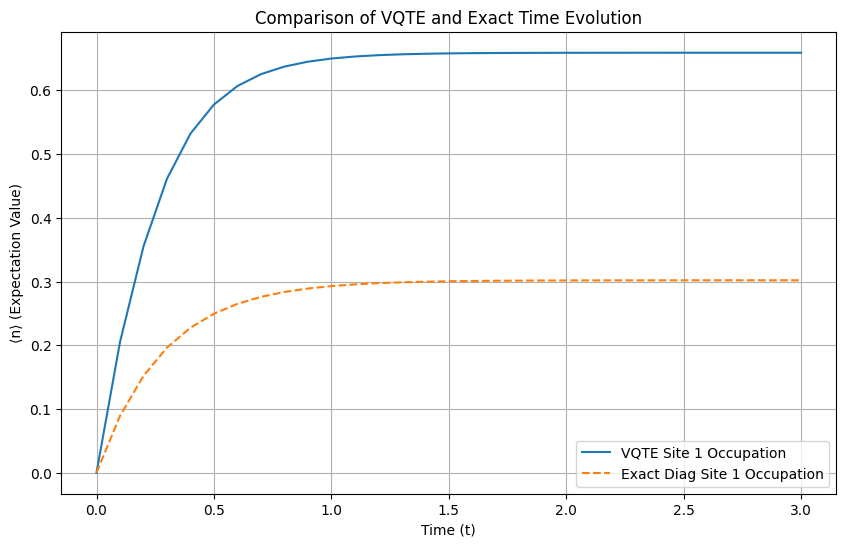

In [3]:
main()